This is a notebook reproducing the `Sgootr` results reported on metastatic colorectal patient CRC01 whose data were made available by [Bian *et al.* (*Science*, 2018)](https://www.science.org/doi/10.1126/science.aao3791), accompanying Figure 1 in the RECOMB 2023 proceeding submission for `Sgootr`.

In [10]:
from os.path import exists
from IPython.display import Image
import numpy as np, pandas as pd, seaborn as sns, networkx as nx, skbio
import matplotlib.pyplot as plt
PATIENT, MAX_ITER = 'CRC01', 40

## 0. Follow `../README.md` to run `Sgootr` on CRC01 data.

In [2]:
if exists('../{}/t{}/'.format(PATIENT, MAX_ITER)):
    print('Run successful.')
else:
    print('Run unsuccessful.')

Run successful.


## 1. Determine the output iteration ($t*$)

RF (distance) refers to Robinson-Foulds measure of tree distance [(Robinson & Foulds, *Mathematical Biosciences* 1981)](https://www.sciencedirect.com/science/article/pii/0025556481900432).

> Sgootr outputs $t∗ = t_i$ where i is the last iteration with $RF(t_i, t_{i−1})$ equals the global minimum across iterations.
> [...]
> Intuitively, we would like to detect an approximate point in the iterative procedure where most non-lineage-informative CpG sites have been pruned out (leading to the initial roughly decreasing trend of RF distance) but most lineage-informative CpG sites still remain (whose further elimination will lead to
increasingly inaccurate distance measurements between cell pairs and therefore increasingly unstable tree
topologies, which is reflected in a once-again increasing trend of RF distance).

The plot reproduces Figure 1c.

Minimum RF distance achieved at iteration 8, with RF distance 26
Iteration 8 has 58573 sites


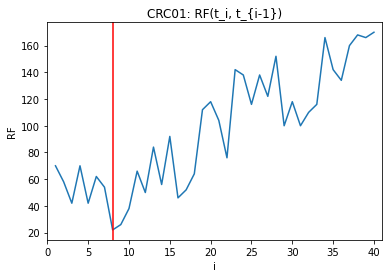

In [3]:
with open('../{}/t{}/RF.txt'.format(PATIENT, MAX_ITER), 'r') as f:
    RF_dists = [int(line.strip().split('\t')[-1]) for line in f.readlines()]

df = pd.DataFrame({'iter':range(1,MAX_ITER+1), 'RF':RF_dists})
ax = sns.lineplot(x=df['iter'],y=df['RF']).set(title=PATIENT+': RF(t_i, t_{i-1})', xlim=(0,MAX_ITER+1),xticks=range(0,MAX_ITER+1,5), xlabel='i')
b = RF_dists[::-1]
i = len(b) - np.argmin(b)
plt.axvline(i, 0,225, color='r')

mask_i = np.load('../{}/t{}/site_mask.npz'.format(PATIENT, i), allow_pickle=True)['mask']
n_sites = int(np.sum(np.isinf(mask_i)))

print('Minimum RF distance achieved at iteration {}, with RF distance {}'.format(i, RF_dists[i]))
print('Iteration {} has {} sites'.format(i, n_sites))

## 2. Show the trees at $t*$

With leaf nodes colored by their lesion of origin:

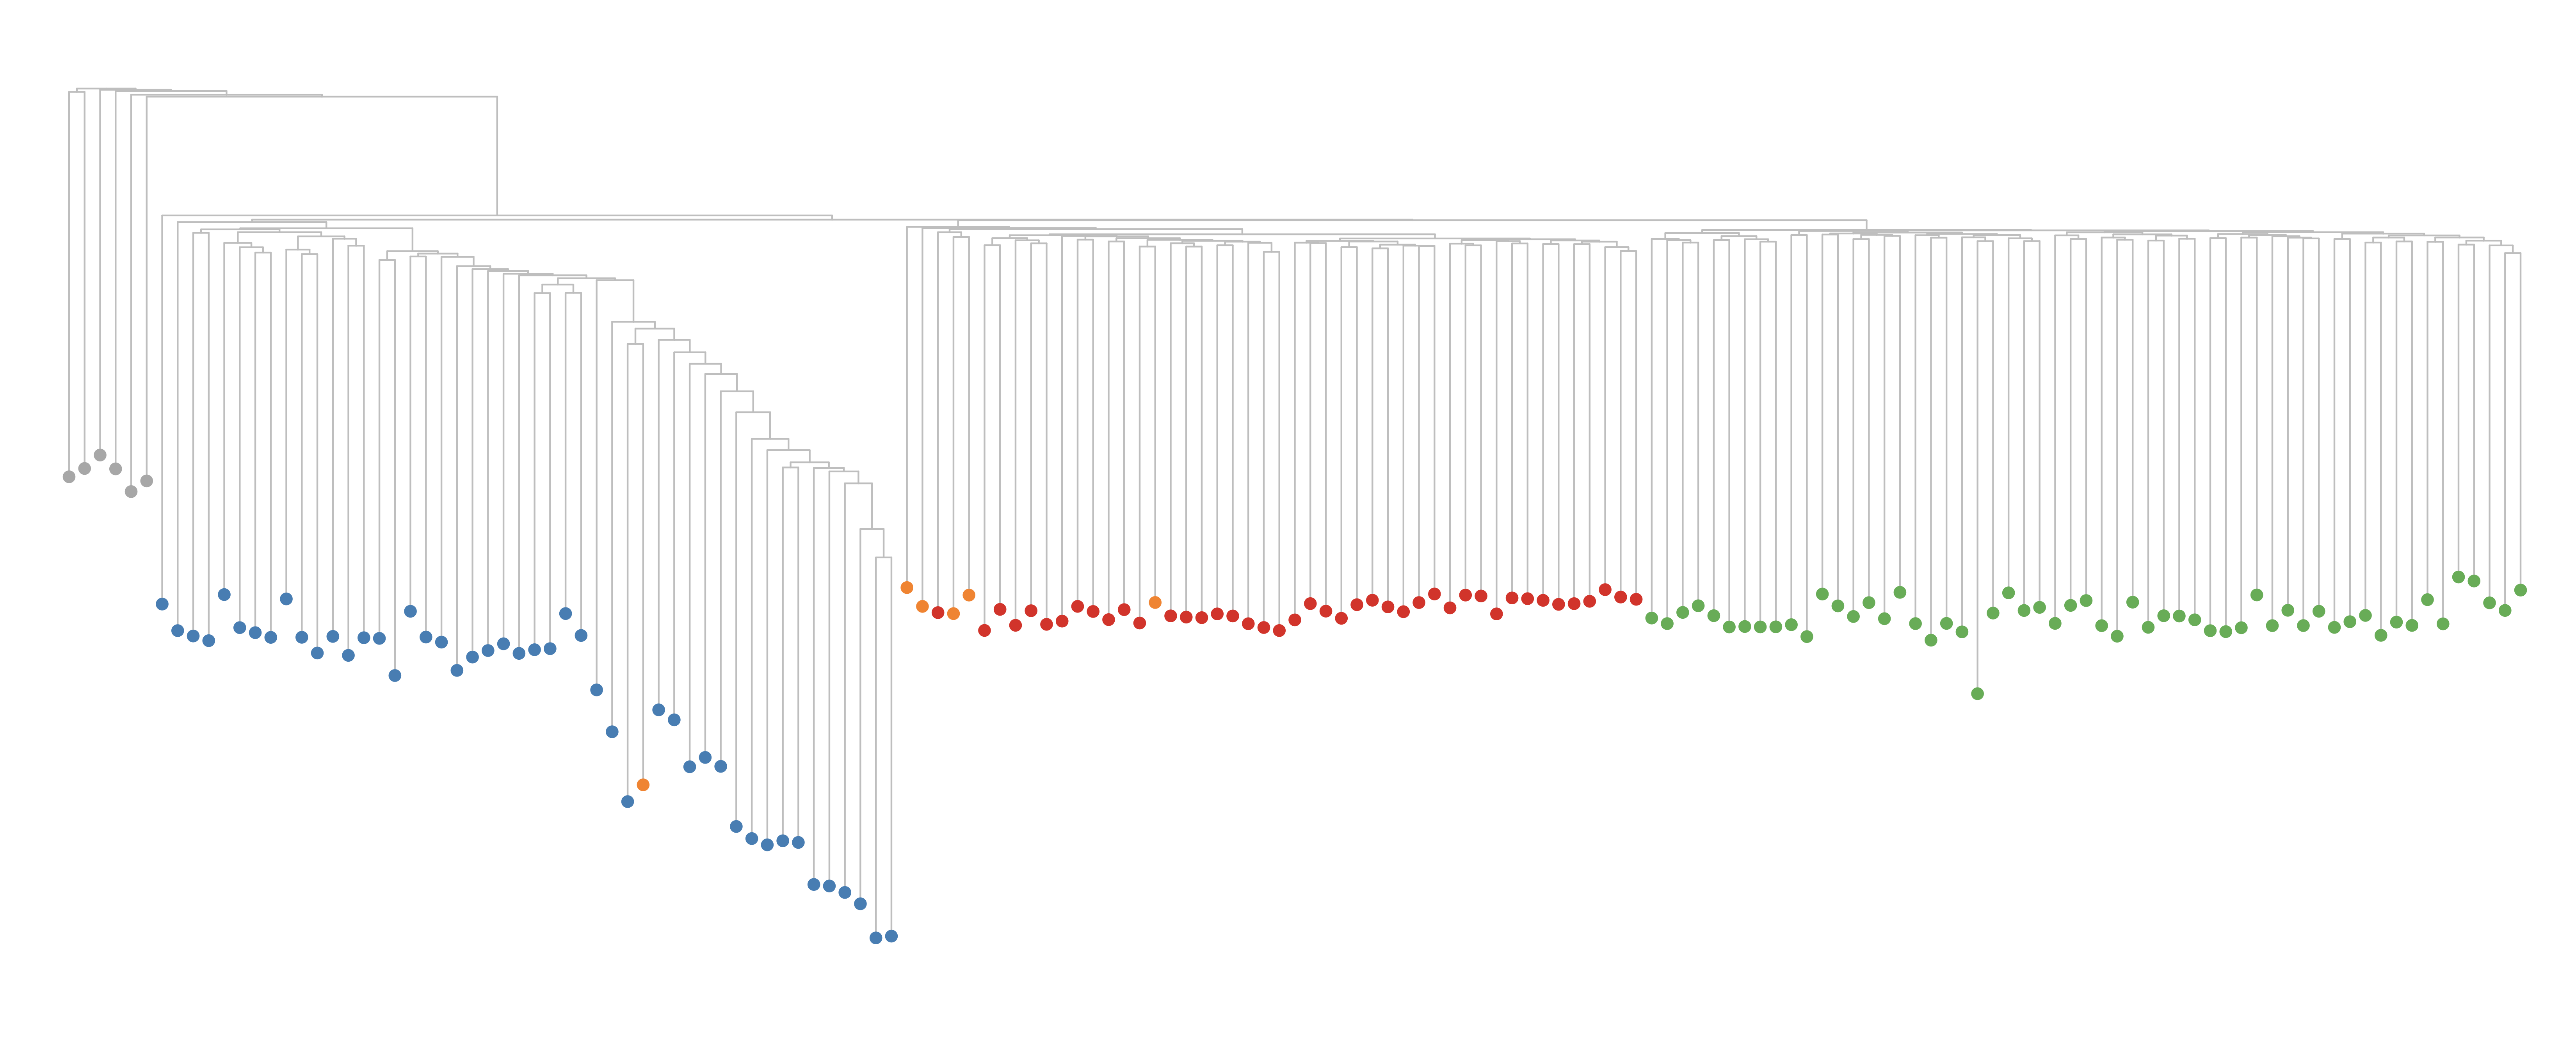

In [4]:
Image(filename='../{}/t{}/lesion.png'.format(PATIENT, i)) 

And with leaf nodes colored by their sampling locations, reproducing Figure 1b.:

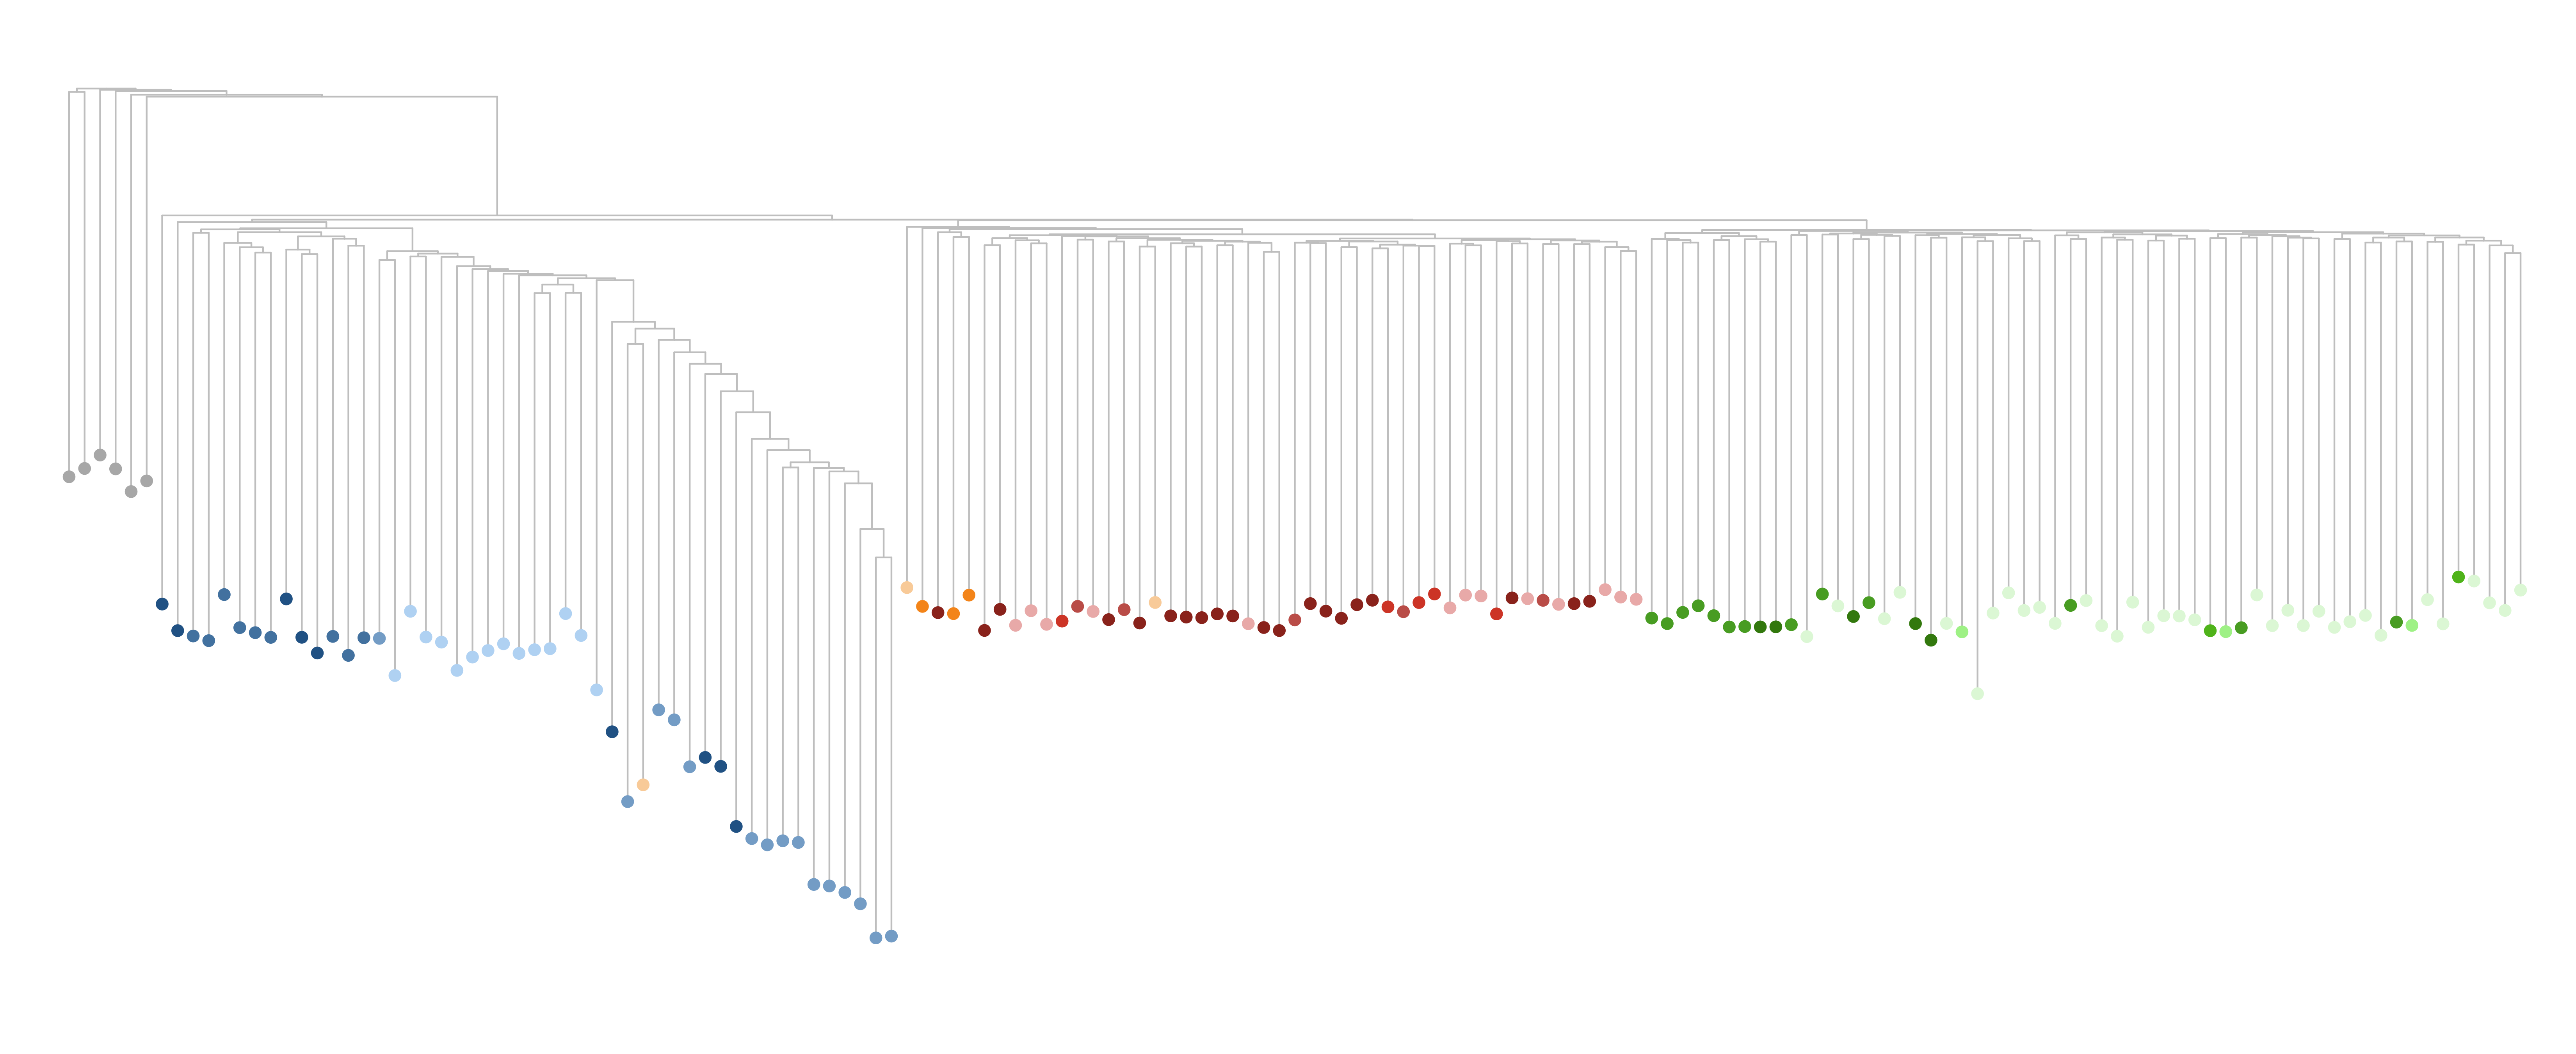

In [5]:
Image(filename='../{}/t{}/sampling_location.png'.format(PATIENT, i)) 

## 3. Determining the migration history using Fitch's algorihtm

> Given a rooted tumor lineage tree $t∗$ produced by `Sgootr` [...], provided that the single cells in the tree are labeled by their lesion of origin, we can infer the underlying tumor migration history, which we represent as a directed multigraph (without self loops) where each vertex represents a distinct lesion and each edge represents a distinct migration event from the source lesion to the target lesion. We accomplish this by first applying the well-known Fitch’s algorithm with slight modification to obtain a unique, maximally parsimonious labeling of the internal nodes of t∗, then identifying the migration events.

In [7]:
m = {0:'NC', 1:'PT', 2:'LN', 3:'ML', 4:'MP'}
k = ['NC'   ,'PT'   ,'LN'   ,'ML'   ,'MP'   ]
o = [['NC'], ['PT'], ['LN'],['ML', 'MP']]# Rank definition of Partial Order
c = ["#A7A7A7", "#487DB2", "#EF8432", "#D1342B", "#68AC57"]
  #   NC PT LN ML MP      
p = [[0, 1, 0, 0, 0], # NC
     [0, 0, 1, 0, 0], # PT     <<< Graph definition of Partial Order:
     [0, 0, 0, 1, 1], # LN         NC < PT < LN < {ML, MP}
     [0, 0, 0, 0, 0], # ML
     [0, 0, 0, 0, 0]] # MP

def fitch(node, locs):
    
    if node.is_tip():
        status_dict[node.name] = {locs[int(node.name)]}, 0
        return {locs[int(node.name)]}, 0
    
    u,v = node.children
    
    Ru, Cu = fitch(u, locs)
    Rv, Cv = fitch(v, locs)
    
    if len(Ru.intersection(Rv)) == 0:
        status_dict[node.name] = Ru.union(Rv), Cu+Cv+1
        return Ru.union(Rv), Cu+Cv+1
    else:
        status_dict[node.name] = Ru.intersection(Rv), Cu+Cv
        return Ru.intersection(Rv), Cu+Cv
    
    
def get_order(state, order):
    for i in range(len(order)):
        if state in order[i]:
            return i
        
        
def assign_transition(node, order, keys):
    
    s, c = status_dict[node.name]
    states = list(s)
    
    if (not node.is_root()) and \
       final_status[node.parent.name] in states: # if node is not root, if possible, assign parent's status
        final_status[node.name] = final_status[node.parent.name]
    else:
        final_status[node.name] = states[np.argmin(np.array([get_order(s, order) for s in states]))]
        if not node.is_root():
            my_status, parent_status = final_status[node.name], final_status[node.parent.name]
            status_map[keys.index(parent_status)][keys.index(my_status)] += 1
    
    if not node.is_tip():
        assign_transition(node.children[0], order, keys)
        assign_transition(node.children[1], order, keys)

# migration events: 7
BAMDPO: 1


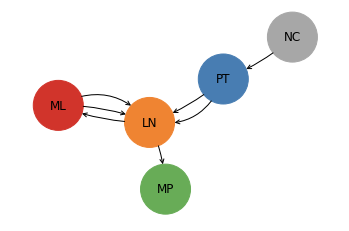

In [12]:
t = skbio.TreeNode.read('../{}/t{}/tree.nwk'.format(PATIENT, i))
cells = np.load('../{}/input.npz'.format(PATIENT), allow_pickle=True)['rows']
labels = [x[:2] for x in cells]
status_dict = {}
R, C = fitch(t.root(), labels)
status_map, final_status = np.zeros((len(k), len(k))), {}
assign_transition(t.root(), o, k)
status_map_binary = np.copy(status_map)
status_map_binary[status_map_binary>0] = 1

print('# migration events: {}'.format(int(np.sum(status_map))))
print('BAMDPO: {}'.format(int(np.sum(np.absolute(np.array(p-status_map_binary))))))

G = nx.from_numpy_matrix(status_map.astype(int), parallel_edges=True, create_using=nx.MultiDiGraph())
G = nx.relabel_nodes(G, m)
pos=nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, \
                       pos, \
                       node_color = c, \
                       node_size = 2500, \
                       alpha = 1)
nx.draw_networkx_labels(G, \
                        pos, \
                        font_size=12)
ax = plt.gca()
ax.set_xlim([1.3*x for x in ax.get_xlim()])
ax.set_ylim([1.3*y for y in ax.get_ylim()])
ax.axis('off')

for e in G.edges:
    ax.annotate("", \
                xy=pos[e[0]], \
                xycoords='data', \
                xytext=pos[e[1]], \
                textcoords='data', \
                arrowprops=dict(arrowstyle='<-', \
                                connectionstyle='arc3, rad={}'.format(str(.3*e[2]+0.1)), \
                                shrinkA=25, shrinkB=25, patchA=None, patchB=None)
               )
plt.show()
plt.close()